## Set-up

In [1]:
import pandas as pd
import os
import sklearn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(os.path.dirname(os.getcwd()))

def _get_r_squared(G):
    '''
    takes x and y and returns r squared

    params:
     - x: list of x values
     - y: list of y values

    returns:
     - r_squared: float
    '''

    degrees = [G.degree(n) for n in G.nodes()]
    mean_degree = np.mean(degrees)

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    ### regression line
    slope, intercept = np.polyfit(x, y, 1)
    # print(f"SLope: {slope*-1}, intercept: {intercept}")
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    plt.title(f"log-log degree distribution, r squared: {round(r_squared,5)}, <k>: {round(mean_degree, 2)}")
    plt.xlabel("log(k)")
    plt.ylabel("log(p(k))")

    plt.scatter(log_k, log_pk)
    plt.plot(x, slope * x + intercept, color="red")
    plt.show()
    
    return r_squared, mean_degree


import data_utils
import network_calculations

presence_path="../../data/presence_matrices/Campylobacter_coli_presence_absence.csv"
pheno_path="../../data/phenotypes/Campylobacter_coli_ciprofloxacin.csv"

presence= data_utils.get_gene_presence_matrix(presence_path)
pheno = data_utils.get_pheno_df(pheno_path)

labeled_data = data_utils.get_labeled_matrix(presence, pheno)


In [2]:
log_odds_df = pd.read_csv("../../data/log_odds_nodes/Campylobacter_coli_ciprofloxacin_log_odds.csv", index_col=0)
log_odds_dict = log_odds_df.to_dict()["log_odds"]
# log_odds_dict

## Correlation Network

### Shell genes

In [ ]:
core = data_utils.get_core(presence, 0.95)
unique = data_utils.get_unique(presence, 0.15)

core_uniqe=core+unique

accessory = data_utils.get_presence_without_gene_set(presence, core_uniqe)
labeled_accessory = data_utils.get_labeled_matrix(accessory, pheno)
corr_accessory_gene = labeled_accessory.corr()

sns.heatmap(corr_accessory_gene, cmap="coolwarm", center=0)

#### Hard threshold

In [ ]:
G = nx.Graph()
genes_num=corr_accessory_gene.shape[0]
for i in range(genes_num):
    for j in range(i+1, genes_num):
        if corr_accessory_gene.iloc[i,j] > 0.5 or corr_accessory_gene.iloc[i,j] < -0.5:
            G.add_edge(corr_accessory_gene.index[i], corr_accessory_gene.columns[j], weight=corr_accessory_gene.iloc[i,j])


layout=nx.spring_layout(G, seed=42)
plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=True, pos=layout, node_size=600, font_size=15)

# nx.write_gml(G, "../../data/graphs/accessory_gene_correlation_C.coli_ciprofloxacin.gml")
# print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

In [ ]:
network_calculations.plot_degree_distribution(G, network_name="Shell genes correlation network with 0.5 hard threshold on C.coli ciprofloxacin data weighted deg dist", weighted=True)

In [ ]:
network_calculations.get_network_stats(G, network_name="Shell genes correlation network with 0.5 hard threshold on C.coli ciprofloxacin data", weighted=True)

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=30)
plt.show()

#### Soft-threshold

The soft-thresholding consists of finding the power of the adjacency matrix that best approximates the scale-free topology. The power is chosen by the function `pickSoftThreshold` from the WGCNA package. The function calculates the scale-free topology fit index for a range of powers and returns the power that best approximates the scale-free topology.

In [ ]:
karate=nx.karate_club_graph()

In [ ]:
def _get_r_squared(G):
    '''
    takes x and y and returns r squared

    params:
     - x: list of x values
     - y: list of y values

    returns:
     - r_squared: float
    '''

    degrees = [G.degree(n) for n in G.nodes()]
    mean_degree = np.mean(degrees)

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    ### regression line
    slope, intercept = np.polyfit(x, y, 1)
    # print(f"SLope: {slope*-1}, intercept: {intercept}")
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    plt.title(f"log-log degree distribution, r squared: {round(r_squared,5)}, <k>: {round(mean_degree, 2)}")
    plt.xlabel("log(k)")
    plt.ylabel("log(p(k))")

    plt.scatter(log_k, log_pk)
    plt.plot(x, slope * x + intercept, color="red")
    plt.show()
    
    return r_squared, mean_degree

print(f"r squared: {_get_r_squared(G)}")

In [ ]:
powers=range(1, 10)
track_r_sq_k = {}
for power in powers:
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix = np.linalg.matrix_power(adj_matrix, power)
    G_power = nx.from_numpy_array(adj_matrix)
    r_sq, k = _get_r_squared(G_power)
    track_r_sq_k[power] = (r_sq, k)

#make a df of powers as rows and r squared and k as columns
df = pd.DataFrame(track_r_sq_k).T
df.columns = ["r_squared", "k"]
df.index.name = "power"
df.reset_index(inplace=True)
df

### Non hypothetical

In [ ]:
presence_nh= data_utils.get_gene_presence_matrix(Rtab_path,True)
# print(presence_nh)

c=network_calculations.get_core(presence_nh)
u=network_calculations.get_unique(presence_nh, 0.05)
acc=c+u
# print(acc)

for i in range(len(acc)):
    if (acc[i] not in list(presence_nh.index)):
        print(acc[i])

presence_nh_acc=data_utils.get_presence_without_gene_set(presence_nh, gene_set=acc)

labeled_annotated = data_utils.get_labeled_matrix(presence_nh_acc, pheno)

corr_genes=labeled_annotated.corr()
sns.heatmap(corr_genes, cmap="coolwarm")
corr_genes

In [ ]:
#create a graph out of the corr matrix with all entries
G = nx.Graph()
genes_num=corr_genes.shape[0]
for i in range(genes_num):
    for j in range(i+1, genes_num):
        if corr_genes.iloc[i,j] > 0.3 or corr_genes.iloc[i,j] < -0.3:
            G.add_edge(corr_genes.index[i], corr_genes.columns[j], weight=corr_genes.iloc[i,j])

In [ ]:
G.number_of_edges()
# G.number_of_nodes()*(G.number_of_nodes()-1)/2

powers=range(1, 3)
track_r_sq_k = {}
for power in powers:
    adj_matrix = nx.to_numpy_array(G)
    adj_matrix = np.linalg.matrix_power(adj_matrix, power)
    G_power = nx.from_numpy_array(adj_matrix)
    r_sq, k = _get_r_squared(G_power)
    track_r_sq_k[power] = (r_sq, k)

#make a df of powers as rows and r squared and k as columns
df = pd.DataFrame(track_r_sq_k).T
df.columns = ["r_squared", "k"]
df.index.name = "power"
df.reset_index(inplace=True)
df

In [ ]:
nx.draw(G, with_labels=True, node_size=200, font_size=8, pos=nx.spring_layout(G, seed=42))

In [ ]:
#get modularity
mod = nx.community.modularity(G, nx.community.louvain_communities(G))
mod
#color by community
communities = nx.community.louvain_communities(G)

colors = sns.color_palette("Set2", len(communities))

plt.figure(figsize=(10, 10))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), nodelist=community, node_color=colors[i], node_size=200)
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42))

In [ ]:
#get degree dist
network_calculations.plot_degree_distribution(G, network_name="Accessory non hypothetocal genes correlation network with 0.3 hard threshold on C.coli ciprofloxacin data deg dist", weighted=False)

network_calculations.plot_degree_distribution(G, network_name="Accessory non hypothetocal genes correlation network with 0.3 hard threshold on C.coli ciprofloxacin data weighted deg dist", weighted=True)

In [ ]:
nx.set_node_attributes(G, log_odds_dict, name="log_odds")

In [ ]:
dict(G.nodes(data=True))

In [ ]:
nx.write_gml(G, "../../data/graphs/accessory_non_hypo_gene_correlation_C.coli_ciprofloxacin.gml")
nx.write_edgelist(G, "../../data/graphs/accessory_non_hypo_gene_correlation_C.coli_ciprofloxacin.txt")
nx.write_graphml(G, "../../data/graphs/accessory_non_hypo_gene_correlation_C.coli_ciprofloxacin.graphml")

### All genes

In [3]:
#removing all the genes with st dev=0 from the presence absence matrix
presence= pd.read_csv("../../data/presence_matrices/Campylobacter_coli_presence_absence.csv", index_col=0)
for gene in presence.columns:
    if presence[gene].std() == 0:
        presence.drop(gene, axis=1, inplace=True)

cor_matrix=presence.corr()


In [4]:
cor_matrix.shape

(6995, 6995)

In [ ]:
# cor_matrix.to_csv("../../updates/april2/FULL_correlation_matrix.csv")

#### Unsigned network

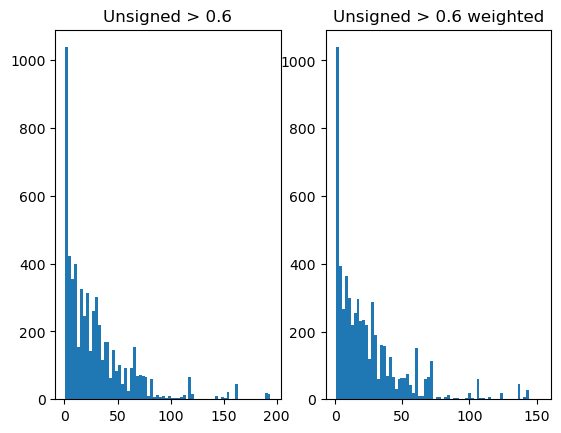

In [5]:
#test on 0.6 cor

t=round(0.6,2)
G = nx.Graph()
genes_num=cor_matrix.shape[0]
for i in range(genes_num):
    for j in range(i+1, genes_num):
        if cor_matrix.iloc[i,j] > t:
            G.add_edge(cor_matrix.index[i], cor_matrix.columns[j], weight=cor_matrix.iloc[i,j])
degrees = [G.degree(n) for n in G.nodes()]
weighted_degrees = [G.degree(n, weight="weight") for n in G.nodes()]
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=70)
plt.title(f"Unsigned > {round(t,2)}")
plt.subplot(1, 2, 2)
plt.hist(weighted_degrees, bins=70)
plt.title(f"Unsigned > {round(t,2)} weighted")
plt.show()

In [7]:
nx.set_node_attributes(G, log_odds_dict, name="log_odds")

In [8]:
nx.set_node_attributes(G, log_odds_dict, name="log_odds")
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")
nx.write_graphml(G, f"../../data/graphs-2/unsigned_correlation_network_{t}.graphml")

number of nodes: 6063, number of edges: 91727


In [ ]:
thresholds = list(np.arange(0.65, 1.0, 0.05))
for t in thresholds:
    t=round(t,2)
    G = nx.Graph()
    genes_num=cor_matrix.shape[0]
    for i in range(genes_num):
        for j in range(i+1, genes_num):
            if cor_matrix.iloc[i,j] > t:
                G.add_edge(cor_matrix.index[i], cor_matrix.columns[j], weight=cor_matrix.iloc[i,j])
    degrees = [G.degree(n) for n in G.nodes()]
    weighted_degrees = [G.degree(n, weight="weight") for n in G.nodes()]
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=70)
    plt.title(f"Unsigned > {round(t,2)}")
    plt.subplot(1, 2, 2)
    plt.hist(weighted_degrees, bins=70)
    plt.title(f"Unsigned > {round(t,2)} weighted")
    plt.show()

    nx.set_node_attributes(G,log_odds_dict, name="log_odds")

    nx.write_gml(G, f"../../data/graphs/unsigned_full_gene_correlation_C.coli_ciprofloxacin_{t}.gml")

    print("done with ", t)
    print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

In [ ]:
unsigned_G6 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.6.gml")
unsigned_G65 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.65.gml")
unsigned_G7 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.7.gml")
unsigned_G75 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.75.gml")
unsigned_G8 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.8.gml")
unsigned_G85 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.85.gml")
unsigned_G9 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.9.gml")
unsigned_G95 = nx.read_gml("../../data/graphs-2/unsigned_full_gene_correlation_C.coli_ciprofloxacin_0.95.gml")

unsigned_G6_stats = network_calculations.get_network_stats(unsigned_G6, network_name="Unsigned full gene correlation network with 0.6 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G65_stats = network_calculations.get_network_stats(unsigned_G65, network_name="Unsigned full gene correlation network with 0.65 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G7_stats = network_calculations.get_network_stats(unsigned_G7, network_name="Unsigned full gene correlation network with 0.7 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G75_stats = network_calculations.get_network_stats(unsigned_G75, network_name="Unsigned full gene correlation network with 0.75 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G8_stats = network_calculations.get_network_stats(unsigned_G8, network_name="Unsigned full gene correlation network with 0.8 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G85_stats = network_calculations.get_network_stats(unsigned_G85, network_name="Unsigned full gene correlation network with 0.85 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G9_stats = network_calculations.get_network_stats(unsigned_G9, network_name="Unsigned full gene correlation network with 0.9 hard threshold on C.coli ciprofloxacin data", weighted=True)
unsigned_G95_stats = network_calculations.get_network_stats(unsigned_G95, network_name="Unsigned full gene correlation network with 0.95 hard threshold on C.coli ciprofloxacin data", weighted=True)


In [ ]:
unsigned_stats = pd.concat([unsigned_G6_stats, unsigned_G65_stats, unsigned_G7_stats, unsigned_G75_stats, unsigned_G8_stats, unsigned_G85_stats, unsigned_G9_stats, unsigned_G95_stats])
unsigned_stats.reset_index(inplace=True)
unsigned_stats

#### Signed network

In [11]:
t=round(0.7,2)
G = nx.Graph()
genes_num=cor_matrix.shape[0]
for i in range(genes_num):
    for j in range(i+1, genes_num):
        if cor_matrix.iloc[i,j] > t or cor_matrix.iloc[i,j] < -t:
            G.add_edge(cor_matrix.index[i], cor_matrix.columns[j], weight=cor_matrix.iloc[i,j])
degrees = [G.degree(n) for n in G.nodes()]
weighted_degrees = [G.degree(n, weight="weight") for n in G.nodes()]
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=70)
plt.title(f"Unsigned > {round(t,2)}")
plt.subplot(1, 2, 2)
plt.hist(weighted_degrees, bins=70)
plt.title(f"Unsigned > {round(t,2)} weighted")
plt.show()

nx.set_node_attributes(G, log_odds_dict, name="log_odds")
print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")
nx.write_graphml(G, f"../../data/graphs-2/signed_correlation_network_{t}.graphml")

In [ ]:
thresholds = list(np.arange(0.75, 1.0, 0.05))
for t in thresholds:
    G = nx.Graph()
    genes_num=cor_matrix.shape[0]
    for i in range(genes_num):
        for j in range(i+1, genes_num):
            if cor_matrix.iloc[i,j] > t or cor_matrix.iloc[i,j] < -t:
                G.add_edge(cor_matrix.index[i], cor_matrix.columns[j], weight=cor_matrix.iloc[i,j])
    degrees = [G.degree(n) for n in G.nodes()]
    weighted_degrees = [G.degree(n, weight="weight") for n in G.nodes()]
    plt.subplot(1, 2, 1)
    plt.hist(degrees, bins=70)
    plt.title(f"Signed > {round(t,2)}")
    plt.subplot(1, 2, 2)
    plt.hist(weighted_degrees, bins=70)
    plt.title(f"Signed > {round(t,2)} weighted")
    plt.show()

    nx.set_node_attributes(G,log_odds_dict, name="log_odds")

    nx.write_gml(G, f"../../data/graphs/signed_full_gene_correlation_C.coli_ciprofloxacin_{t}.gml")
    print("done with ", t)
    print(f"number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}")

In [ ]:
signed_G6 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.6.gml")
signed_G65 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.65.gml")
signed_G7 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.7.gml")
signed_G75 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.75.gml")
signed_G8 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.8.gml")
signed_G85 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.85.gml")
signed_G9 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.9.gml")
signed_G95 = nx.read_gml("../../data/graphs-2/signed_full_gene_correlation_C.coli_ciprofloxacin_0.95.gml")


signed_G6_stats = network_calculations.get_network_stats(signed_G6, network_name="Signed with 0.6 hard threshold", weighted=True)
signed_G65_stats = network_calculations.get_network_stats(signed_G65, network_name="Signed with 0.65 hard threshold", weighted=True)
signed_G7_stats = network_calculations.get_network_stats(signed_G7, network_name="Signed with 0.7 hard threshold", weighted=True)
signed_G75_stats = network_calculations.get_network_stats(signed_G75, network_name="Signed with 0.75 hard threshold", weighted=True)
signed_G8_stats = network_calculations.get_network_stats(signed_G8, network_name="Signed with 0.8 hard threshold", weighted=True)
signed_G85_stats = network_calculations.get_network_stats(signed_G85, network_name="Signed with 0.85 hard threshold", weighted=True)
signed_G9_stats = network_calculations.get_network_stats(signed_G9, network_name="Signed with 0.9 hard threshold", weighted=True)
signed_G95_stats = network_calculations.get_network_stats(signed_G95, network_name="Signed with 0.95 hard threshold", weighted=True)


In [ ]:
signed_stats = pd.concat([signed_G6_stats, signed_G65_stats, signed_G7_stats, signed_G75_stats, signed_G8_stats, signed_G85_stats, signed_G9_stats, signed_G95_stats])
signed_stats.reset_index(inplace=True)
signed_stats

In [ ]:
#put signeed and unsigned stats together in a csv
all_stats = pd.concat([signed_stats, unsigned_stats])
all_stats.to_csv("../../data/stats/signed_unsigned_network_metrics.csv")
all_stats

#### Soft-threshold

soft thresholding using the function `pickSoftThreshold` from the WGCNA package was 4 given the correlation matrix, will try to use this value to build the network.

In [ ]:
#make the cor matrix to the power of 4
adj_matrix = np.array(cor_matrix)
adj_matrix = np.linalg.matrix_power(adj_matrix, 4)
G = nx.from_numpy_array(adj_matrix)
network_calculations.get_network_stats(G, network_name="soft thresholding 4 power on C.coli ciprofloxacin", weighted=False)

In [ ]:
nx.set_node_attributes(G, log_odds_dict, name="log_odds")
nx.write_gml(G, "../../data/graphs/soft_thresholding_4_power_C.coli_ciprofloxacin.gml")

plt.subplot(1, 2, 1)
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=70)
plt.title("4 power soft unweighted")
plt.subplot(1, 2, 2)
weighted_degrees = [G.degree(n, weight="weight") for n in G.nodes()]
plt.hist(weighted_degrees, bins=70)
plt.title("4 power soft weighted")
plt.show()